In [ ]:
#!pip install pycaret
#!pip install shap
#%pip install imbalanced-learn

# Resolução do CASE: Analisando dados de RH – “Avaliando o Turnover”

Autor: Murilo Carlos Martins

In [1]:
# Import das bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
from imblearn.over_sampling import SMOTE
from pycaret import classification
from collections import Counter
import plotly.express as px

#%matplotlib inline
pd.set_option('display.max_columns', None)

## Carregando a base de dados

In [3]:
# Carrega a base de dados
# Use a raw string (r"...") to avoid unicode escape errors on Windows paths
file_path = r"C:\Users\muril\OneDrive\01 - Projetos\07 - Streamlit\Dashboard Painel Profissional\Projetos\Turn Over\WA_Fn-UseC_-HR-Employee-Attrition.csv"
data = pd.read_csv(file_path)
data

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,1,2061,3,Male,41,4,2,Laboratory Technician,4,Married,2571,12290,4,Y,No,17,3,3,80,1,17,3,3,5,2,0,3
1466,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,1,2062,4,Male,42,2,3,Healthcare Representative,1,Married,9991,21457,4,Y,No,15,3,1,80,1,9,5,3,7,7,1,7
1467,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,2,Male,87,4,2,Manufacturing Director,2,Married,6142,5174,1,Y,Yes,20,4,2,80,1,6,0,3,6,2,0,3
1468,49,No,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,4,Male,63,2,2,Sales Executive,2,Married,5390,13243,2,Y,No,14,3,4,80,0,17,3,2,9,6,0,8


In [ ]:
# Dá pra ver que a base possui 1470 observações relacioandas a 35 colunas.

In [4]:
# Transformando as colunas categoricas segundo o mapeamento dado no descritivo da base

mapping = {
    "Education": {1: "Below College", 2: "College", 3: "Bachelor", 4: "Master", 5: "Doctor"},
    "EnvironmentSatisfaction": {1: "Low", 2: "Medium", 3: "High", 4: "Very High"},
    "JobInvolvement": {1: "Low", 2: "Medium", 3: "High", 4: "Very High"},
    "JobSatisfaction": {1: "Low", 2: "Medium", 3: "High", 4: "Very High"},
    "PerformanceRating": {1: "Low", 2: "Good", 3: "Excellent", 4: "Outstanding"},
    "RelationshipSatisfaction": {1: "Low", 2: "Medium", 3: "High", 4: "Very High"},
    "WorkLifeBalance": {1: "Bad", 2: "Good", 3: "Better", 4: "Best"}
}

for column, mapping in mapping.items():
    data[column] = data[column].map(mapping)
data

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,College,Life Sciences,1,1,Medium,Female,94,High,2,Sales Executive,Very High,Single,5993,19479,8,Y,Yes,11,Excellent,Low,80,0,8,0,Bad,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,Below College,Life Sciences,1,2,High,Male,61,Medium,2,Research Scientist,Medium,Married,5130,24907,1,Y,No,23,Outstanding,Very High,80,1,10,3,Better,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,College,Other,1,4,Very High,Male,92,Medium,1,Laboratory Technician,High,Single,2090,2396,6,Y,Yes,15,Excellent,Medium,80,0,7,3,Better,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,Master,Life Sciences,1,5,Very High,Female,56,High,1,Research Scientist,High,Married,2909,23159,1,Y,Yes,11,Excellent,High,80,0,8,3,Better,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,Below College,Medical,1,7,Low,Male,40,High,1,Laboratory Technician,Medium,Married,3468,16632,9,Y,No,12,Excellent,Very High,80,1,6,3,Better,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,No,Travel_Frequently,884,Research & Development,23,College,Medical,1,2061,High,Male,41,Very High,2,Laboratory Technician,Very High,Married,2571,12290,4,Y,No,17,Excellent,High,80,1,17,3,Better,5,2,0,3
1466,39,No,Travel_Rarely,613,Research & Development,6,Below College,Medical,1,2062,Very High,Male,42,Medium,3,Healthcare Representative,Low,Married,9991,21457,4,Y,No,15,Excellent,Low,80,1,9,5,Better,7,7,1,7
1467,27,No,Travel_Rarely,155,Research & Development,4,Bachelor,Life Sciences,1,2064,Medium,Male,87,Very High,2,Manufacturing Director,Medium,Married,6142,5174,1,Y,Yes,20,Outstanding,Medium,80,1,6,0,Better,6,2,0,3
1468,49,No,Travel_Frequently,1023,Sales,2,Bachelor,Medical,1,2065,Very High,Male,63,Medium,2,Sales Executive,Medium,Married,5390,13243,2,Y,No,14,Excellent,Very High,80,0,17,3,Good,9,6,0,8


### Análise Exploratória inicial

Aqui é feita a analise inicial da distribuição dos dados


### Checando valores nulos

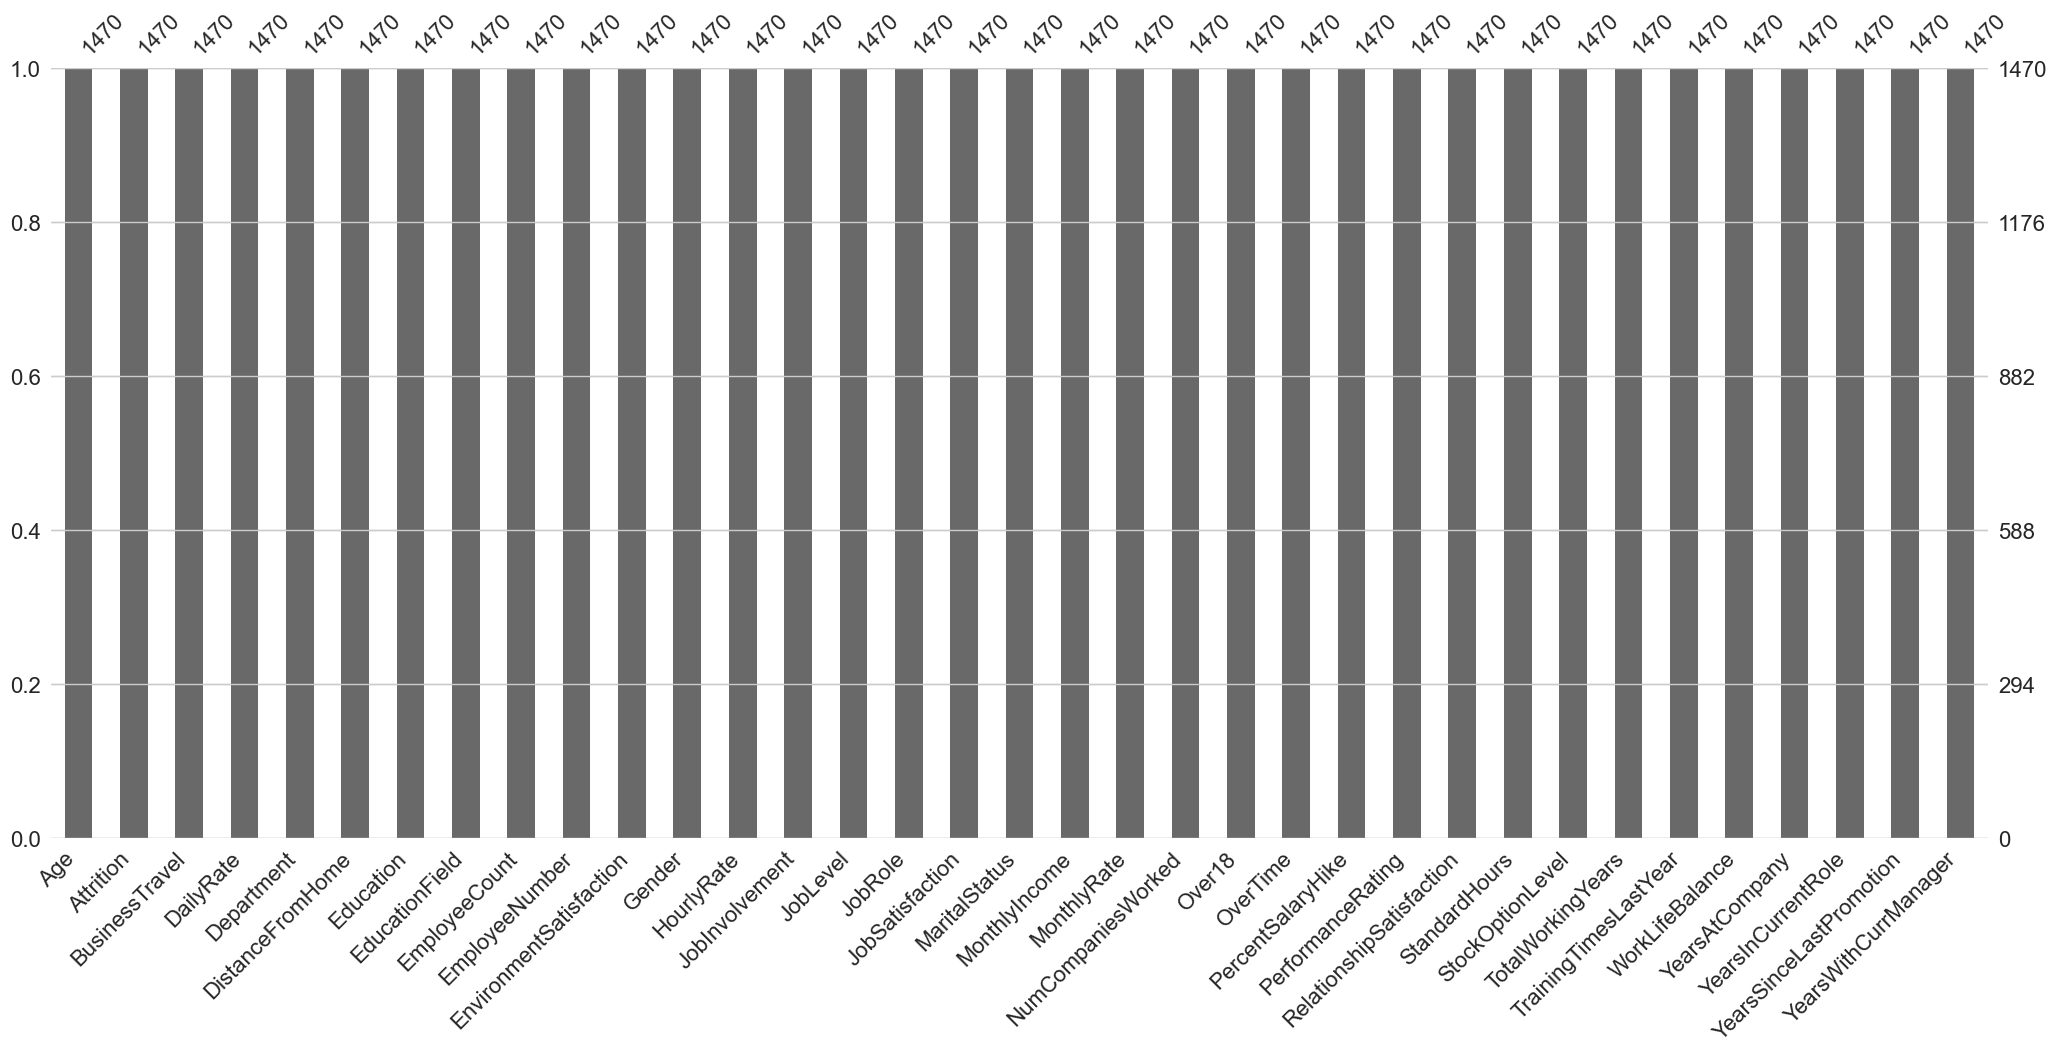

In [5]:
## pode checar também com o missingno (meu preferido)
import missingno as msno
msno.bar(data)
plt.show()
# Esse gráfico de barra mostra que todas as colunas estão com o mesmo número de observações
# (nenhum valor nulo presente).

<Axes: >

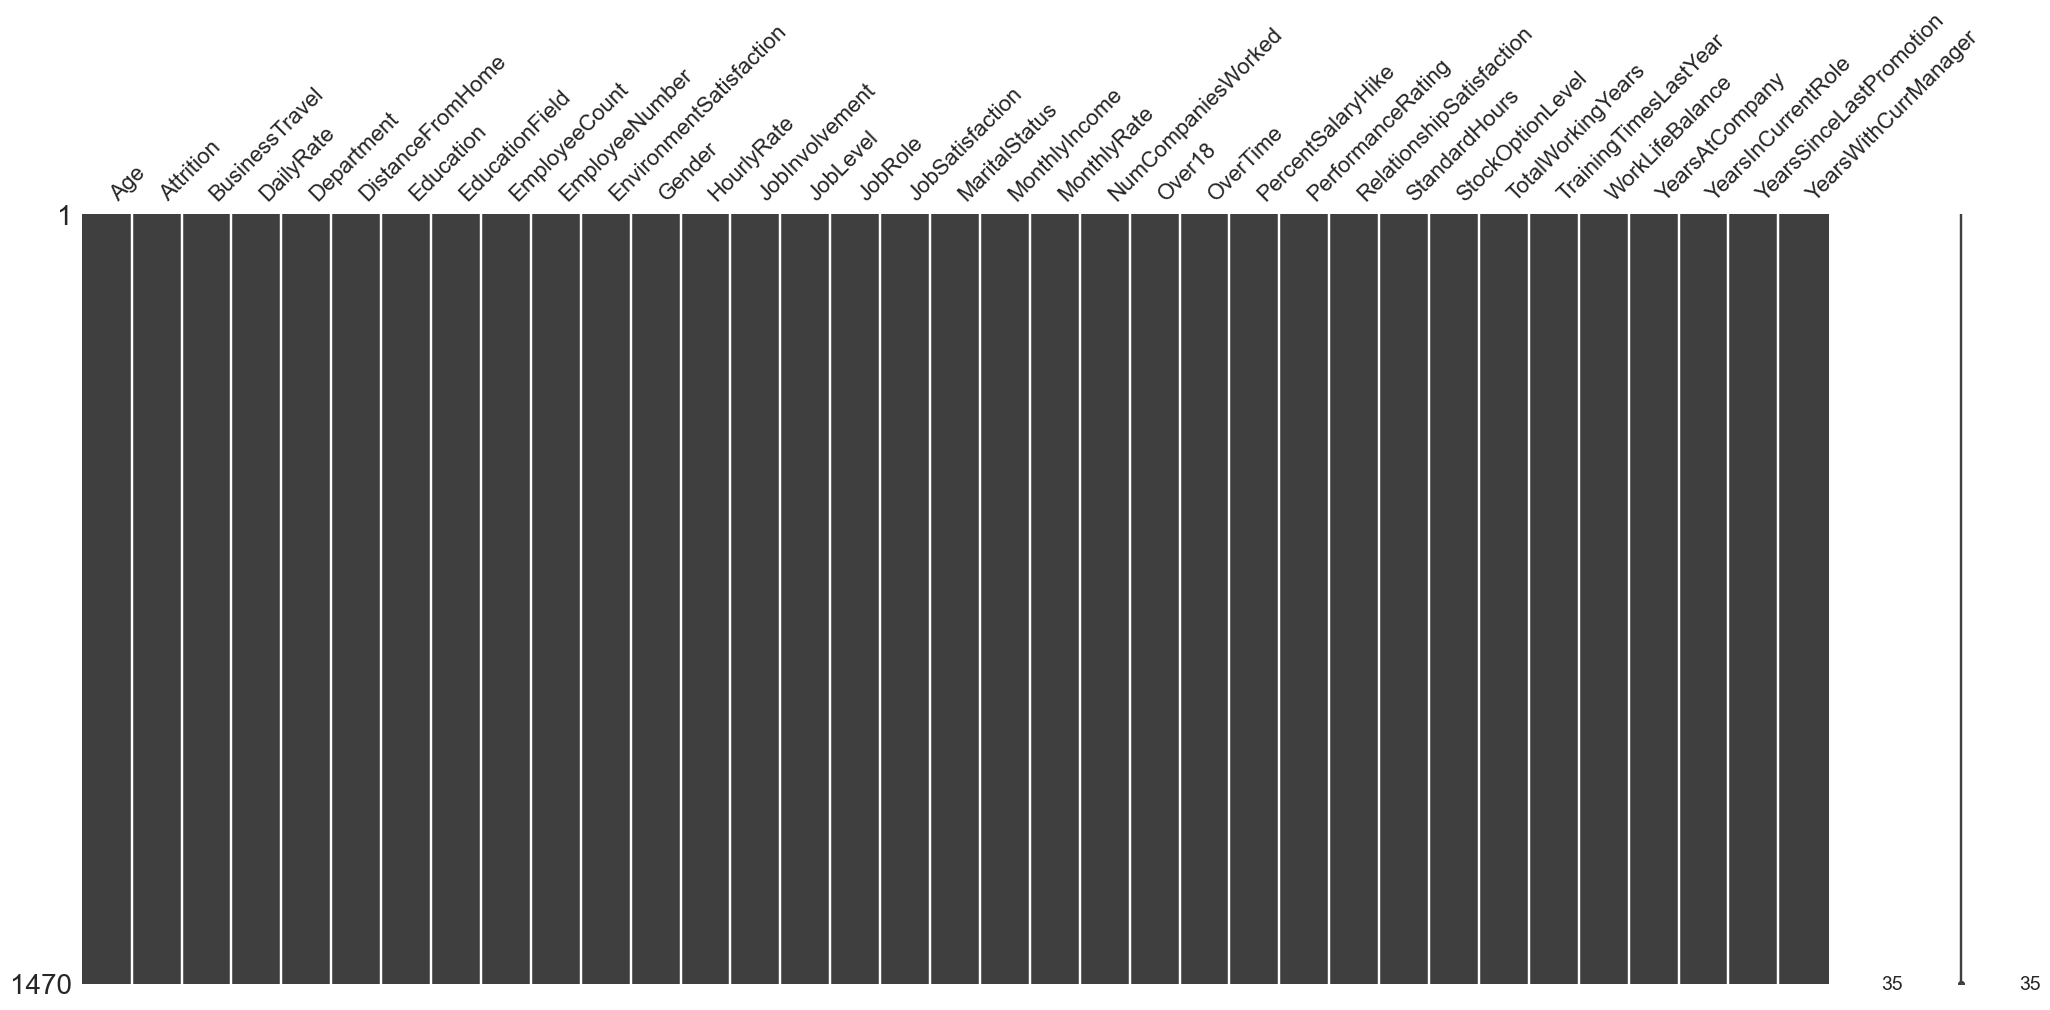

In [ ]:
msno.matrix(data)
# Alternativa ao outro gráfico feito com o seaborn para missing values

#para saber mais sobre o missingno https://www.hashtagtreinamentos.com/missingno-no-python

### Excluindo linhas duplicadas (caso houver)

In [7]:
data.drop_duplicates(inplace=True) # O inplace=True garante que o dataframe "data" será reescrito, sem as duplicatas
data #como o número de linhas permanece o mesmo, sabemos que não havia dados duplicados

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,College,Life Sciences,1,1,Medium,Female,94,High,2,Sales Executive,Very High,Single,5993,19479,8,Y,Yes,11,Excellent,Low,80,0,8,0,Bad,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,Below College,Life Sciences,1,2,High,Male,61,Medium,2,Research Scientist,Medium,Married,5130,24907,1,Y,No,23,Outstanding,Very High,80,1,10,3,Better,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,College,Other,1,4,Very High,Male,92,Medium,1,Laboratory Technician,High,Single,2090,2396,6,Y,Yes,15,Excellent,Medium,80,0,7,3,Better,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,Master,Life Sciences,1,5,Very High,Female,56,High,1,Research Scientist,High,Married,2909,23159,1,Y,Yes,11,Excellent,High,80,0,8,3,Better,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,Below College,Medical,1,7,Low,Male,40,High,1,Laboratory Technician,Medium,Married,3468,16632,9,Y,No,12,Excellent,Very High,80,1,6,3,Better,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,No,Travel_Frequently,884,Research & Development,23,College,Medical,1,2061,High,Male,41,Very High,2,Laboratory Technician,Very High,Married,2571,12290,4,Y,No,17,Excellent,High,80,1,17,3,Better,5,2,0,3
1466,39,No,Travel_Rarely,613,Research & Development,6,Below College,Medical,1,2062,Very High,Male,42,Medium,3,Healthcare Representative,Low,Married,9991,21457,4,Y,No,15,Excellent,Low,80,1,9,5,Better,7,7,1,7
1467,27,No,Travel_Rarely,155,Research & Development,4,Bachelor,Life Sciences,1,2064,Medium,Male,87,Very High,2,Manufacturing Director,Medium,Married,6142,5174,1,Y,Yes,20,Outstanding,Medium,80,1,6,0,Better,6,2,0,3
1468,49,No,Travel_Frequently,1023,Sales,2,Bachelor,Medical,1,2065,Very High,Male,63,Medium,2,Sales Executive,Medium,Married,5390,13243,2,Y,No,14,Excellent,Very High,80,0,17,3,Good,9,6,0,8


In [8]:
# Estatísticas descritivas
print(data.describe())

               Age    DailyRate  DistanceFromHome  EmployeeCount  \
count  1470.000000  1470.000000       1470.000000         1470.0   
mean     36.923810   802.485714          9.192517            1.0   
std       9.135373   403.509100          8.106864            0.0   
min      18.000000   102.000000          1.000000            1.0   
25%      30.000000   465.000000          2.000000            1.0   
50%      36.000000   802.000000          7.000000            1.0   
75%      43.000000  1157.000000         14.000000            1.0   
max      60.000000  1499.000000         29.000000            1.0   

       EmployeeNumber   HourlyRate     JobLevel  MonthlyIncome   MonthlyRate  \
count     1470.000000  1470.000000  1470.000000    1470.000000   1470.000000   
mean      1024.865306    65.891156     2.063946    6502.931293  14313.103401   
std        602.024335    20.329428     1.106940    4707.956783   7117.786044   
min          1.000000    30.000000     1.000000    1009.000000   20

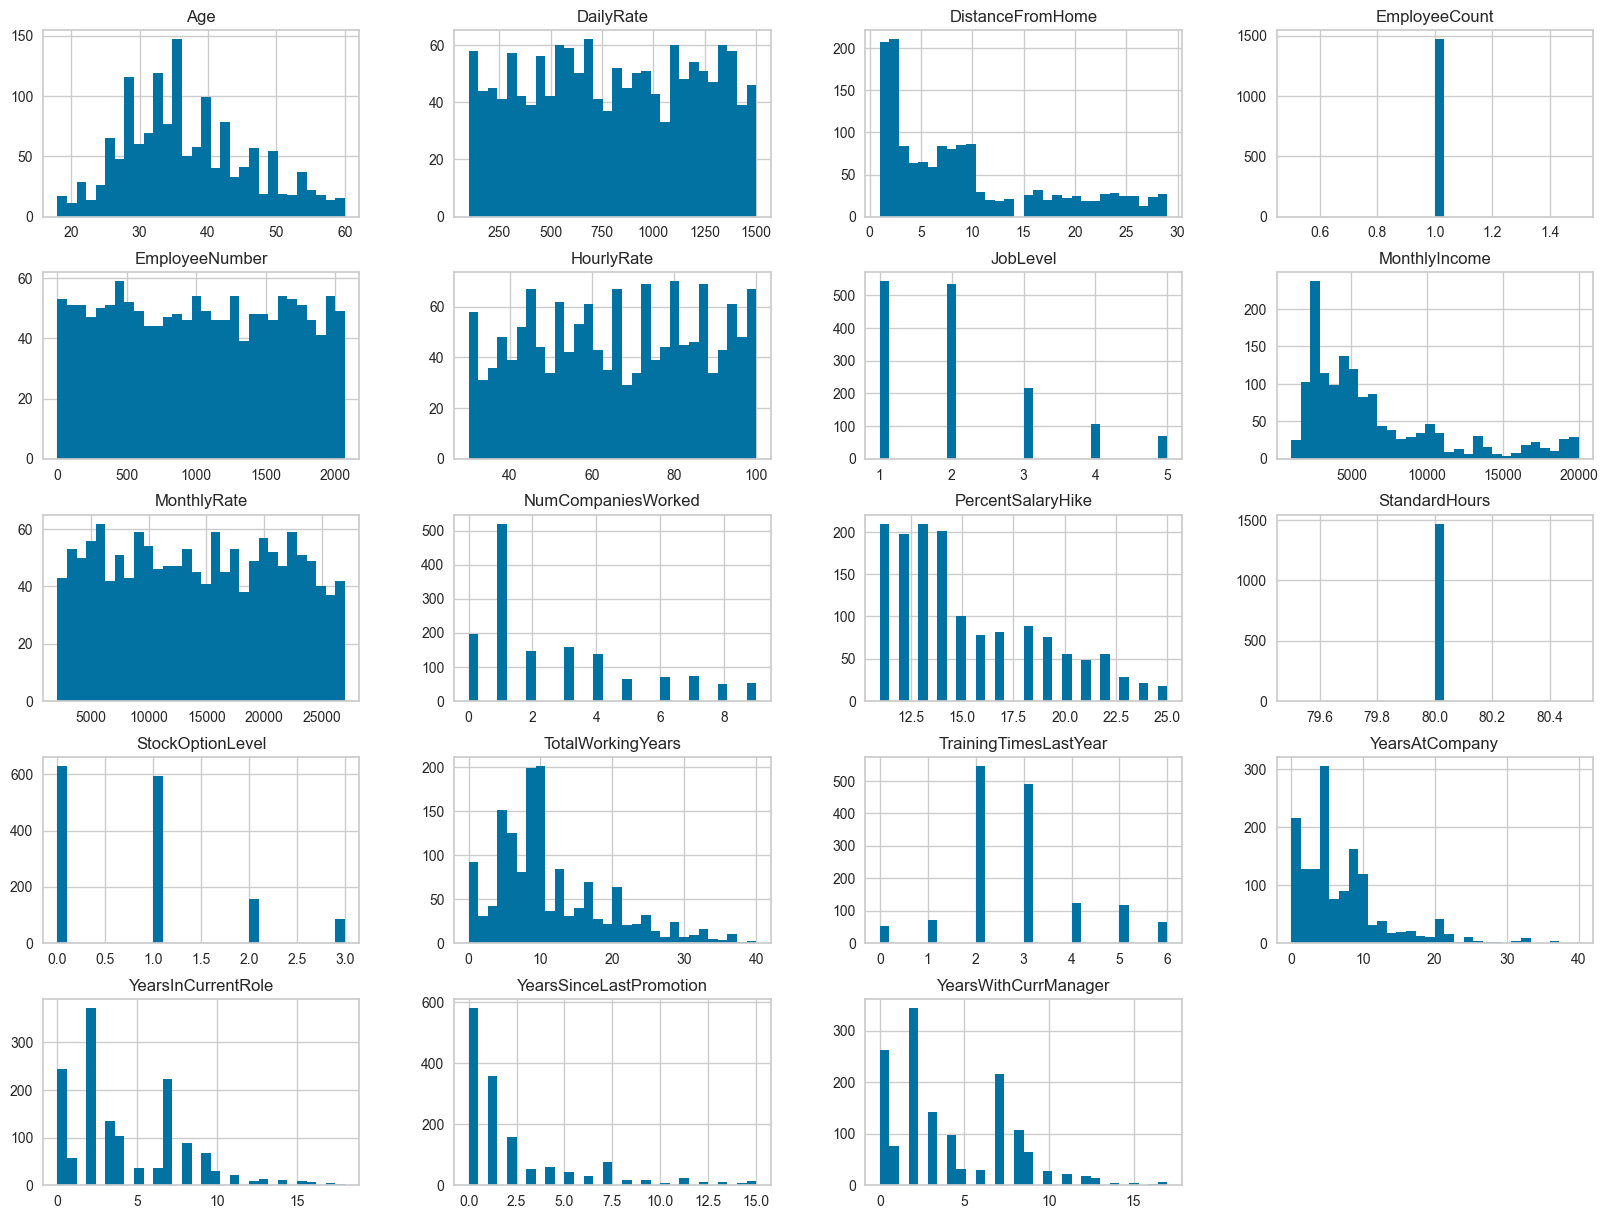

In [9]:
# Visualização da distribuição das variáveis numéricas
data.hist(bins=30, figsize=(20, 15))
plt.show()

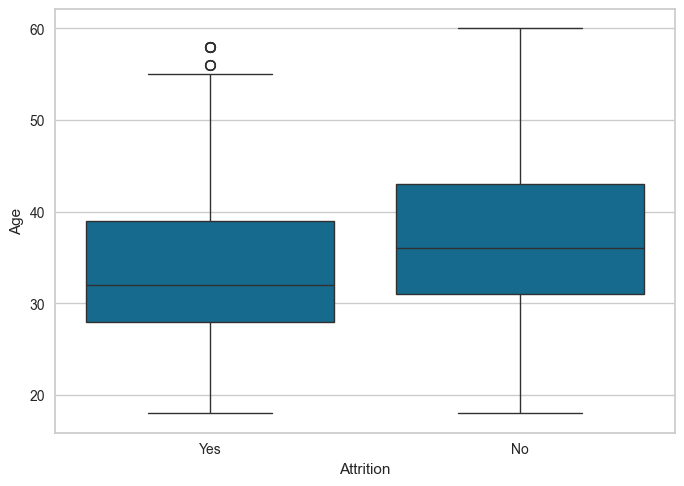

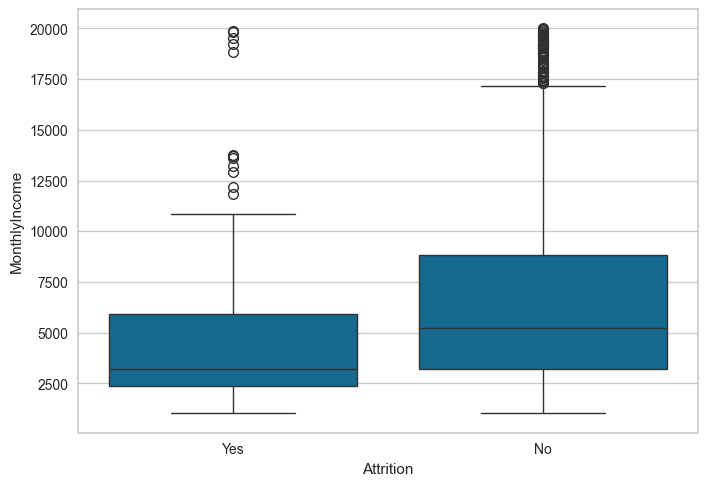

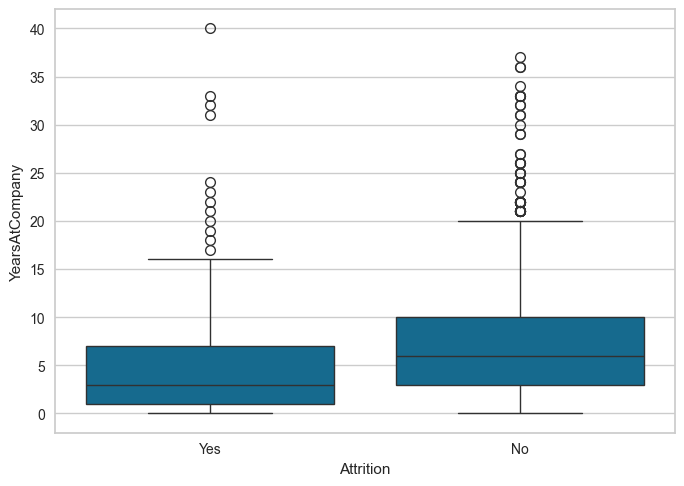

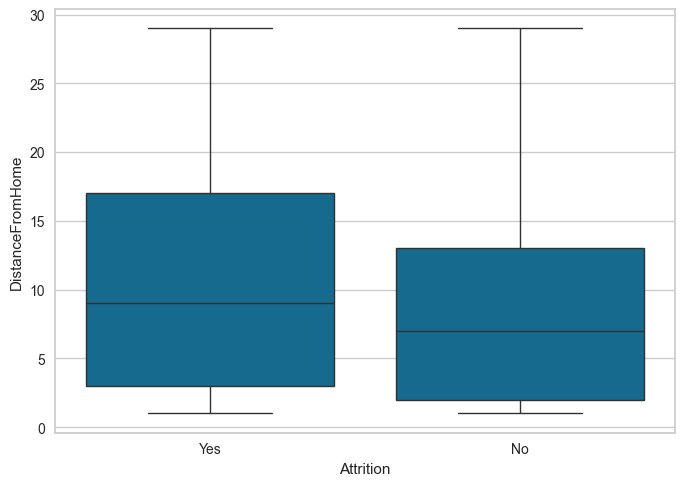

In [10]:
# Boxplots para comparar a distribuição de variáveis numéricas entre os grupos de Attrition
numerical_features = ['Age', 'MonthlyIncome', 'YearsAtCompany', 'DistanceFromHome']
for feature in numerical_features:
    sns.boxplot(data=data, x='Attrition', y=feature)
    plt.show()

In [11]:
# Taxa de turnover geral
attrition_rate = data['Attrition'].value_counts(normalize=True) * 100
print(attrition_rate)

Attrition
No     83.877551
Yes    16.122449
Name: proportion, dtype: float64


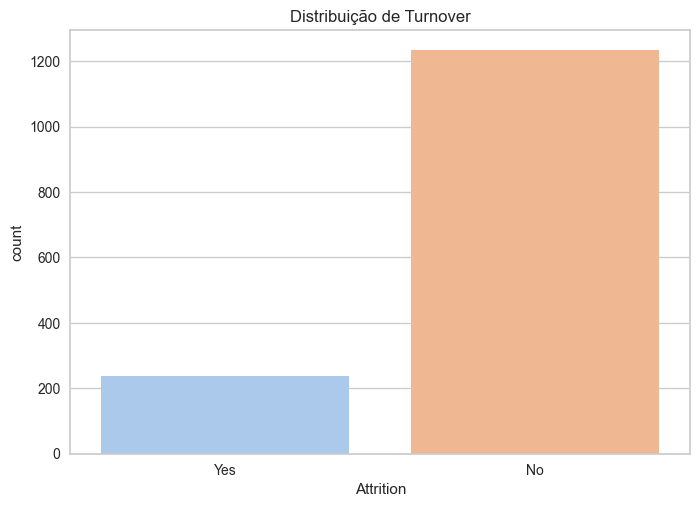

In [12]:
# Gráfico da taxa de turnover - Percebe-se que se trata de um conjunto de dados desbalanceado, onde tem-se um volume maior de um desfecho (sem attrition). Isso pode causar problemas durante a modelagem.
sns.countplot(data=data, x='Attrition', palette='pastel')
plt.title('Distribuição de Turnover')
plt.show()

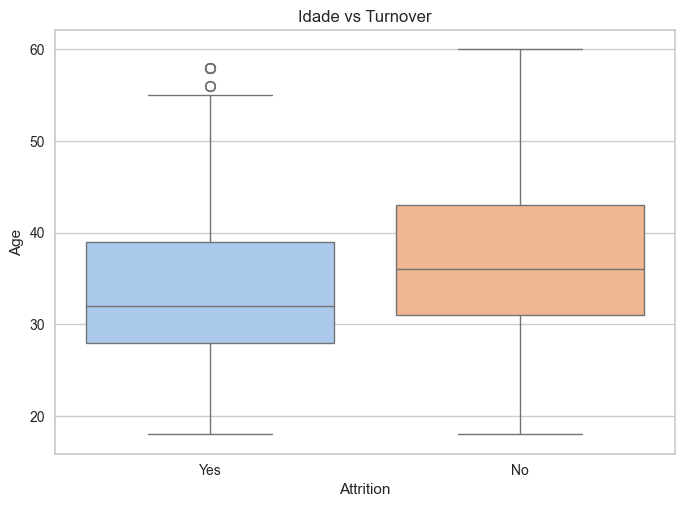

In [13]:
# Análise por Idade
sns.boxplot(data=data, x='Attrition', y='Age', palette='pastel')
plt.title('Idade vs Turnover')
plt.show()

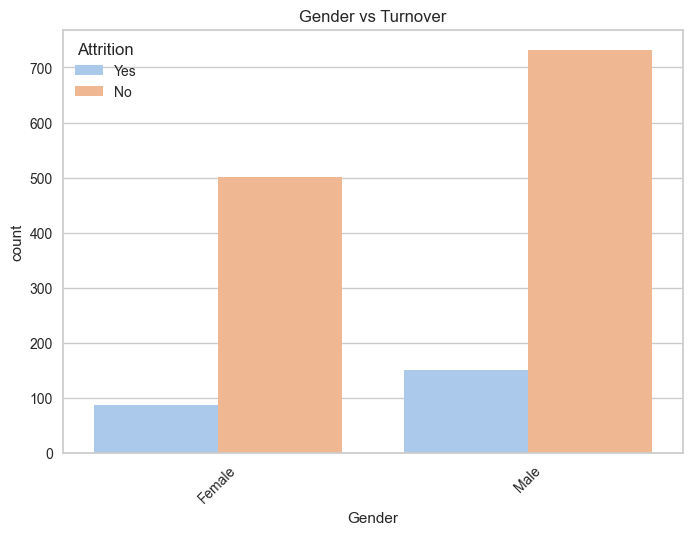

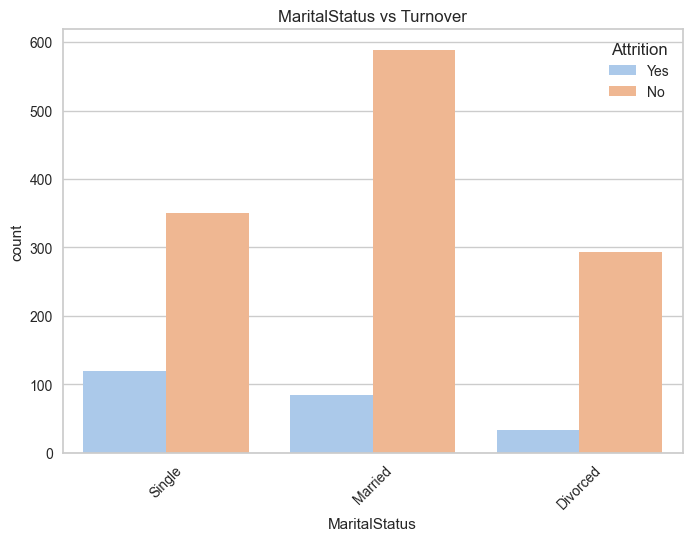

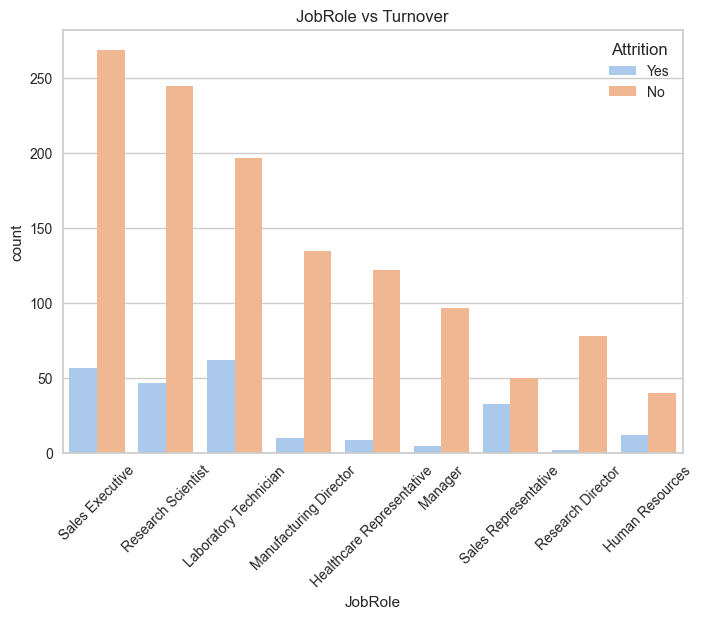

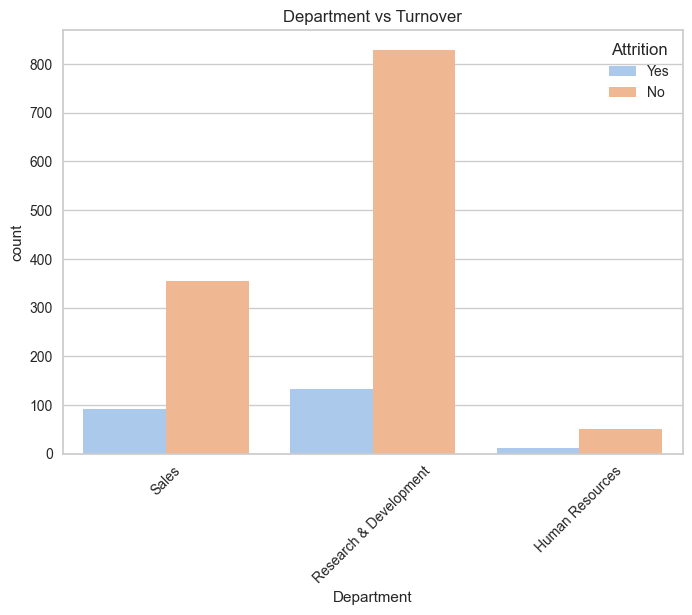

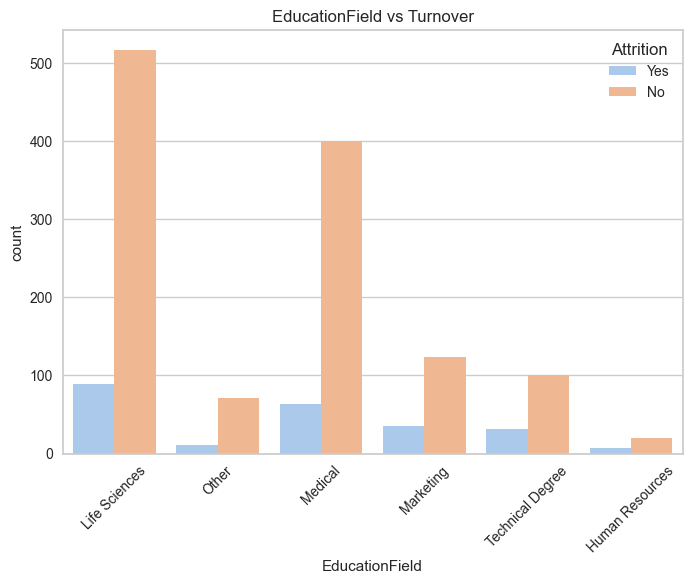

In [14]:
# Fatores demográficos e profissionais
categorical_vars = ['Gender', 'MaritalStatus', 'JobRole', 'Department', 'EducationField']
for var in categorical_vars:
    sns.countplot(data=data, x=var, hue='Attrition', palette='pastel')
    plt.title(f'{var} vs Turnover')
    plt.xticks(rotation=45)
    plt.show()

In [15]:
#categorical_features = ['Age', 'MonthlyIncome', 'Department', 'JobSatisfaction', 'MonthlyIncome', 'YearsAtCompany', 'Gender', 'JobLevel', 'YearsInCurrentRole' ]
categorical_features = ['BusinessTravel', 'Department', 'Education',
       'EducationField', 'EnvironmentSatisfaction', 'Gender', 'JobInvolvement',
       'JobRole', 'JobSatisfaction', 'MaritalStatus', 'Over18', 'OverTime',
       'PerformanceRating', 'RelationshipSatisfaction', 'WorkLifeBalance']

for feature in categorical_features:

    counts = data[["EmployeeCount", "Attrition", feature]].groupby(["Attrition", feature]).count().reset_index()
    fig = px.bar(counts, x=feature, y="EmployeeCount", color="Attrition", color_discrete_map={"Yes": "red", "No": "blue"}, barmode="stack")

    #Customize the layout
    fig.update_layout(
        margin=dict(l=10, r=10, t=40, b=40),
        height=500,     # Fixed height
        width=600,      # Fixed width
        paper_bgcolor='rgba(0,0,0,0)',  # Transparent background for the whole figure
        plot_bgcolor='rgba(0,0,0,0)',   # Transparent background for the plot area
        yaxis_title='Employees',
        xaxis_title=feature,
        barmode='group',  # Group bars based on the category column
        xaxis=dict(
            showline=False,
            zeroline=False,
            gridcolor='rgba(0,0,0,0)',
        ))
    
    #Show the plot
    fig.show()

In [16]:
categorical_features = ['BusinessTravel', 'Department', 'Education',
       'EducationField', 'EnvironmentSatisfaction', 'Gender', 'JobInvolvement',
       'JobRole', 'JobSatisfaction', 'MaritalStatus', 'Over18', 'OverTime',
       'PerformanceRating', 'RelationshipSatisfaction', 'WorkLifeBalance']

for feature in categorical_features:
    # Calcula os totais por grupo de 'Attrition'
    totals = data.groupby(["Attrition"])["EmployeeCount"].sum().reset_index().rename(columns={"EmployeeCount": "TotalCount"})
    
    # Junta os totais ao DataFrame original
    counts = data[["EmployeeCount", "Attrition", feature]].groupby(["Attrition", feature]).count().reset_index()
    counts = counts.merge(totals, on="Attrition")
    
    # Calcula as proporções
    counts["Proportion"] = counts["EmployeeCount"] / counts["TotalCount"]

    # Adiciona uma coluna formatada com a proporção em porcentagem com duas casas decimais
    counts["ProportionText"] = (counts["Proportion"] * 100).round(2).astype(str) + "%"
    
    # Cria o gráfico de barras com proporções
    fig = px.bar(
        counts,
        x="Attrition",
        y="Proportion",
        color=feature,
        barmode="stack",
        text="ProportionText",
        labels={"Proportion": "Proportion", "Attrition": "Attrition"},
        title="Proportion of Feature Categories by Attrition"
    )

        #Customize the layout
    fig.update_layout(
        margin=dict(l=10, r=10, t=40, b=40),
        height=500,     # Fixed height
        width=600,      # Fixed width
        paper_bgcolor='rgba(0,0,0,0)',  # Transparent background for the whole figure
        plot_bgcolor='rgba(0,0,0,0)',   # Transparent background for the plot area
        yaxis_title='Percentage',
        xaxis_title=feature,
        barmode='stack',  # Group bars based on the category column
        yaxis=dict(
        gridcolor='rgba(200, 200, 200, 0.5)',  # Set grid color (optional)
        dtick=5  # Set the tick interval (adjust this value as needed)
        # xaxis=dict(
        #     showline=False,
        #     zeroline=False,
        #     gridcolor='rgba(0,0,0,0)',
        ))
    
    #Show the plot
    fig.show()

## Modelagem

### Abordagem I - Escolha de um modelo para testes iniciais (Random Forest)

In [17]:
# Transformando variáveis categóricas em numéricas
df_encoded = pd.get_dummies(data, drop_first=True, dtype=int)
df_encoded

,Age,DailyRate,DistanceFromHome,EmployeeCount,EmployeeNumber,HourlyRate,JobLevel,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition_Yes,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,Education_Below College,Education_College,Education_Doctor,Education_Master,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,EnvironmentSatisfaction_Low,EnvironmentSatisfaction_Medium,EnvironmentSatisfaction_Very High,Gender_Male,JobInvolvement_Low,JobInvolvement_Medium,JobInvolvement_Very High,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,JobSatisfaction_Low,JobSatisfaction_Medium,JobSatisfaction_Very High,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes,PerformanceRating_Outstanding,RelationshipSatisfaction_Low,RelationshipSatisfaction_Medium,RelationshipSatisfaction_Very High,WorkLifeBalance_Best,WorkLifeBalance_Better,WorkLifeBalance_Good
0,41,1102,1,1,1,94,2,5993,19479,8,11,80,0,8,0,6,4,0,5,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,1,0,0,0,0,0
1,49,279,8,1,2,61,2,5130,24907,1,23,80,1,10,3,10,7,1,7,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0
2,37,1373,2,1,4,92,1,2090,2396,6,15,80,0,7,3,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0
3,33,1392,3,1,5,56,1,2909,23159,1,11,80,0,8,3,8,7,3,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0
4,27,591,2,1,7,40,1,3468,16632,9,12,80,1,6,3,2,2,2,2,0,0,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,884,23,1,2061,41,2,2571,12290,4,17,80,1,17,3,5,2,0,3,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0
1466,39,613,6,1,2062,42,3,9991,21457,4,15,80,1,9,5,7,7,1,7,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0
1467,27,155,4,1,2064,87,2,6142,5174,1,20,80,1,6,0,6,2,0,3,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,1,1,0,1,0,0,1,0
1468,49,1023,2,1,2065,63,2,5390,13243,2,14,80,0,17,3,9,6,0,8,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,1


In [18]:
# Separando variáveis preditivas do desfecho (Attrition)
X = df_encoded.drop('Attrition_Yes', axis=1)
y = df_encoded['Attrition_Yes']
df_encoded

,Age,DailyRate,DistanceFromHome,EmployeeCount,EmployeeNumber,HourlyRate,JobLevel,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition_Yes,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,Education_Below College,Education_College,Education_Doctor,Education_Master,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,EnvironmentSatisfaction_Low,EnvironmentSatisfaction_Medium,EnvironmentSatisfaction_Very High,Gender_Male,JobInvolvement_Low,JobInvolvement_Medium,JobInvolvement_Very High,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,JobSatisfaction_Low,JobSatisfaction_Medium,JobSatisfaction_Very High,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes,PerformanceRating_Outstanding,RelationshipSatisfaction_Low,RelationshipSatisfaction_Medium,RelationshipSatisfaction_Very High,WorkLifeBalance_Best,WorkLifeBalance_Better,WorkLifeBalance_Good
0,41,1102,1,1,1,94,2,5993,19479,8,11,80,0,8,0,6,4,0,5,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,1,0,0,0,0,0
1,49,279,8,1,2,61,2,5130,24907,1,23,80,1,10,3,10,7,1,7,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0
2,37,1373,2,1,4,92,1,2090,2396,6,15,80,0,7,3,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0
3,33,1392,3,1,5,56,1,2909,23159,1,11,80,0,8,3,8,7,3,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0
4,27,591,2,1,7,40,1,3468,16632,9,12,80,1,6,3,2,2,2,2,0,0,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,884,23,1,2061,41,2,2571,12290,4,17,80,1,17,3,5,2,0,3,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0
1466,39,613,6,1,2062,42,3,9991,21457,4,15,80,1,9,5,7,7,1,7,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0
1467,27,155,4,1,2064,87,2,6142,5174,1,20,80,1,6,0,6,2,0,3,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,1,1,0,1,0,0,1,0
1468,49,1023,2,1,2065,63,2,5390,13243,2,14,80,0,17,3,9,6,0,8,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,1


In [19]:
# Dividindo os dados em treino e teste (20% para teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
X_train.shape

(1176, 60)

In [21]:
X_test.shape

(294, 60)

In [22]:
y_train.shape

(1176,)

In [23]:
y_test.shape

(294,)

In [24]:
# Aplicando SMOTE para balanceamento dos dados
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Verificando o balanceamento
print("Antes do balanceamento:", Counter(y_train))
print("Depois do balanceamento:", Counter(y_resampled))


Antes do balanceamento: Counter({0: 978, 1: 198})
Depois do balanceamento: Counter({0: 978, 1: 978})


In [25]:
# Treinando o modelo Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_resampled, y_resampled)

RandomForestClassifier(random_state=42)

In [26]:
# Avaliação do modelo
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.95      0.92       255
           1       0.46      0.28      0.35        39

    accuracy                           0.86       294
   macro avg       0.68      0.62      0.64       294
weighted avg       0.84      0.86      0.85       294

[[242  13]
 [ 28  11]]


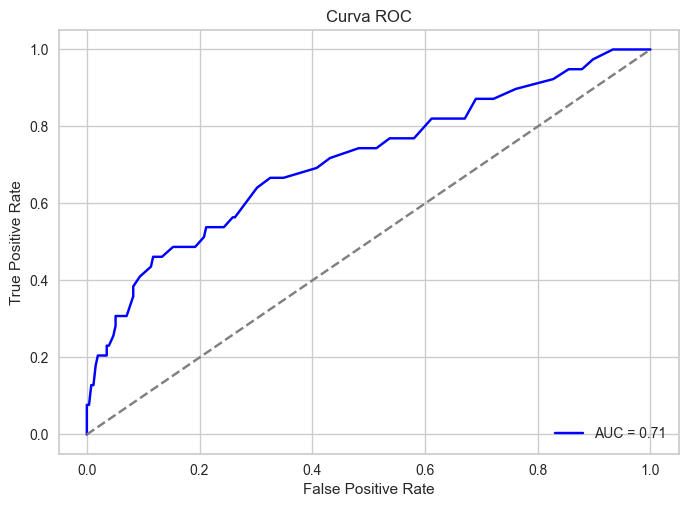

In [27]:
# Curva ROC
fpr, tpr, _ = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])
plt.figure()
plt.plot(fpr, tpr, color='blue', label='AUC = {:.2f}'.format(roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

In [28]:
# Importância das variáveis
importances = rf_model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

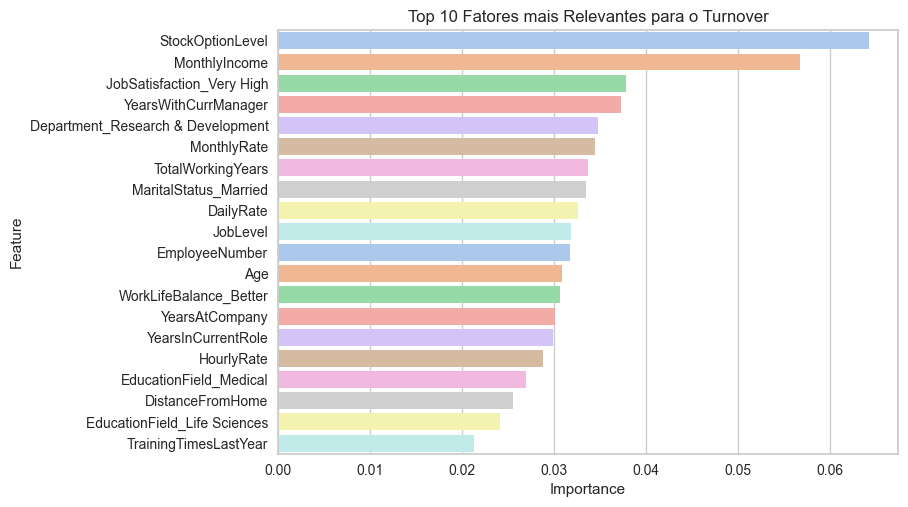

In [29]:
# Visualizar as variáveis mais importantes
sns.barplot(data=importance_df.head(20), x='Importance', y='Feature', palette='pastel')
plt.title('Top 10 Fatores mais Relevantes para o Turnover')
plt.show()

Interpretação prática

Esse é um caso clássico de classe desbalanceada — o número de pessoas que saem é bem menor que o número que fica.
Por isso, o modelo aprende mais sobre “quem fica” e tem dificuldade em prever “quem sai”.

Mesmo assim, um AUC de 0.71 indica que o modelo está moderadamente bom para discriminar as duas classes — melhor do que o acaso (0.5), mas ainda longe de um modelo confiável para decisões críticas.

### Modelagem utilizando o Pycaret

In [30]:
from sklearn.preprocessing import LabelEncoder


In [31]:
clf = classification.setup(data, 
                           target = 'Attrition', 
                           #ignore_features = [], 
                           fix_imbalance = True,
                           session_id = 7)

  File "c:\Users\muril\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\muril\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\muril\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\muril\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


,Description,Value
0,Session id,7
1,Target,Attrition
2,Target type,Binary
3,Target mapping,"No: 0, Yes: 1"
4,Original data shape,"(1470, 35)"
5,Transformed data shape,"(2167, 73)"
6,Transformed train set shape,"(1726, 73)"
7,Transformed test set shape,"(441, 73)"
8,Numeric features,19
9,Categorical features,15


In [ ]:
# O próprio Pycaret já realiza a divisão do dataset em treino e teste, realiza o balanceamento dos dados e treina os modelos com o método de cross-vaçidação (neste caso utilizando o método Stratified KFold) 

In [32]:
# Treina vários modelos e seleciona os 3 melhores
_3_best_models = classification.compare_models(n_select=3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8688,0.7855,0.8688,0.8561,0.8498,0.3934,0.4286,0.1590
gbc,Gradient Boosting Classifier,0.8649,0.7949,0.8649,0.8492,0.8449,0.3729,0.4056,0.3040
lightgbm,Light Gradient Boosting Machine,0.8639,0.7874,0.8639,0.8526,0.8413,0.3547,0.3986,0.4740
rf,Random Forest Classifier,0.8581,0.7945,0.8581,0.8480,0.8181,0.2390,0.3169,0.1140
et,Extra Trees Classifier,0.8572,0.8065,0.8572,0.8360,0.8205,0.2528,0.3140,0.1120
ada,Ada Boost Classifier,0.8484,0.8078,0.8484,0.8381,0.8413,0.3913,0.3966,0.1270
dummy,Dummy Classifier,0.8387,0.5000,0.8387,0.7034,0.7651,0.0000,0.0000,0.0430
dt,Decision Tree Classifier,0.7920,0.6270,0.7920,0.7966,0.7931,0.2439,0.2455,0.0570
lda,Linear Discriminant Analysis,0.7580,0.8086,0.7580,0.8456,0.7840,0.3559,0.3899,0.0550
ridge,Ridge Classifier,0.7551,0.8092,0.7551,0.8450,0.7816,0.3523,0.3867,0.0530


In [33]:
# O XGboost apresentou as melhores métricas. Por isso seleciono ele para gerar novas analises
xgboost = classification.create_model('xgboost')
# Estes são os resultados dos 10 treinamentos da cross-validacao

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8835,0.6509,0.8835,0.8783,0.8602,0.4041,0.4655
1,0.8544,0.7313,0.8544,0.8507,0.8524,0.4305,0.4308
2,0.8835,0.8448,0.8835,0.8783,0.8602,0.4041,0.4655
3,0.9126,0.8680,0.9126,0.9117,0.9030,0.6202,0.6492
4,0.8252,0.7346,0.8252,0.7839,0.7936,0.1701,0.1917
5,0.8835,0.8263,0.8835,0.8808,0.8624,0.4467,0.5034
6,0.8447,0.8577,0.8447,0.8251,0.8306,0.3434,0.3543
7,0.8738,0.8037,0.8738,0.8621,0.8542,0.4186,0.4573
8,0.8641,0.7743,0.8641,0.8473,0.8462,0.3921,0.4181


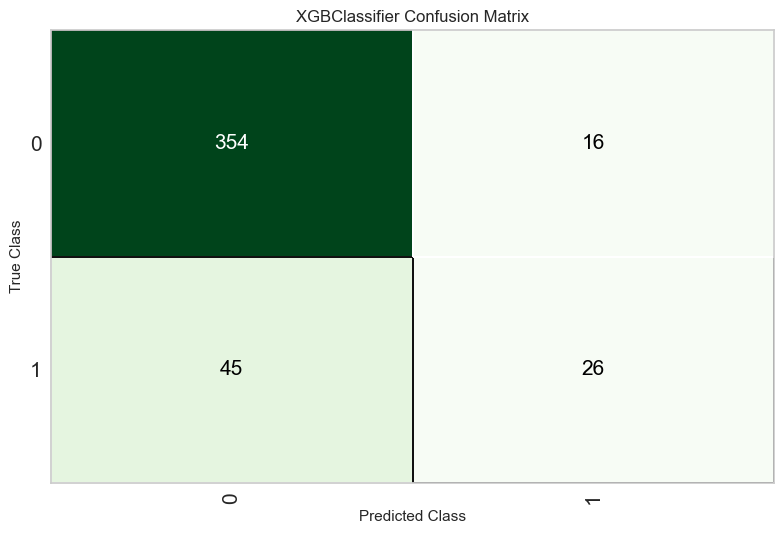

In [34]:
# Avaliando a matriz de confusão
classification.plot_model(xgboost, 'confusion_matrix')

# 354 (Verdadeiros Negativos - VN): O modelo classificou corretamente 354 exemplos como classe 0.
# 16 (Falsos Positivos - FP): O modelo classificou erroneamente 16 exemplos da classe 0 como classe 1.
# 44 (Falsos Negativos - FN): O modelo classificou erroneamente 44 exemplos da classe 1 como classe 0.
# 27 (Verdadeiros Positivos - VP): O modelo classificou corretamente 27 exemplos como classe 1.

# O modelo apresenta uma alta acurácia (86.4%), mas esta métrica pode ser enganosa se as classes forem desbalanceadas.
# A precisão (62.8%) para a classe 1 é moderada, mas o recall (38%) é baixo, indicando que o modelo está deixando muitos exemplos da classe 1 sem classificação correta.
# O F1-Score (47.2%) reflete o equilíbrio entre precisão e recall, destacando a dificuldade do modelo em classificar a classe 1 corretamente.
# A especificidade (95.7%) é alta, indicando que o modelo é muito bom em identificar corretamente a classe 0.
# Conclusão:
# O modelo funciona bem para a classe 0, mas tem dificuldades em detectar corretamente a classe 1. Para melhorar o desempenho na classe 1, você pode:

# Ajustar o limiar de classificação para aumentar o recall.
# Usar técnicas para lidar com classes desbalanceadas, como sobremostragem da classe 1 (SMOTE) ou ajuste de pesos.
# Considerar métricas como F1-Score ou Recall em vez de Acurácia ao avaliar o modelo.

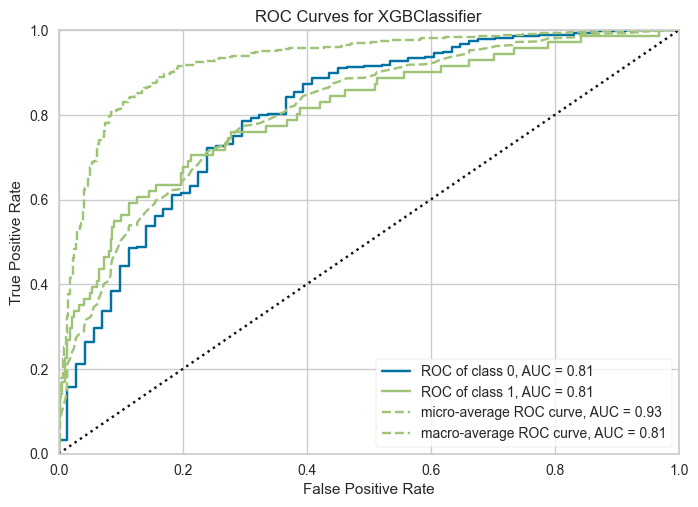

In [35]:
# Avaliando a curva ROC do XGBoost
classification.plot_model(xgboost, 'auc')
# A curva 

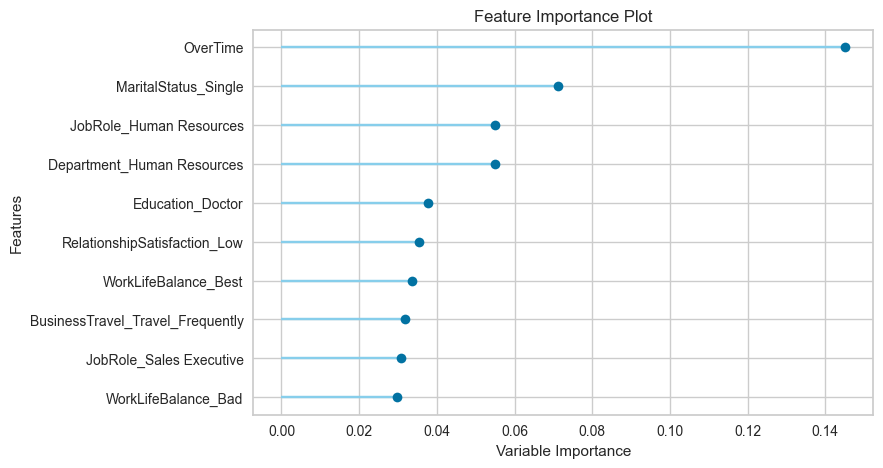

In [ ]:
classification.plot_model(xgboost, 'feature')
# As três features mais importantes são as que se destacavam nos gráficos de proporção.

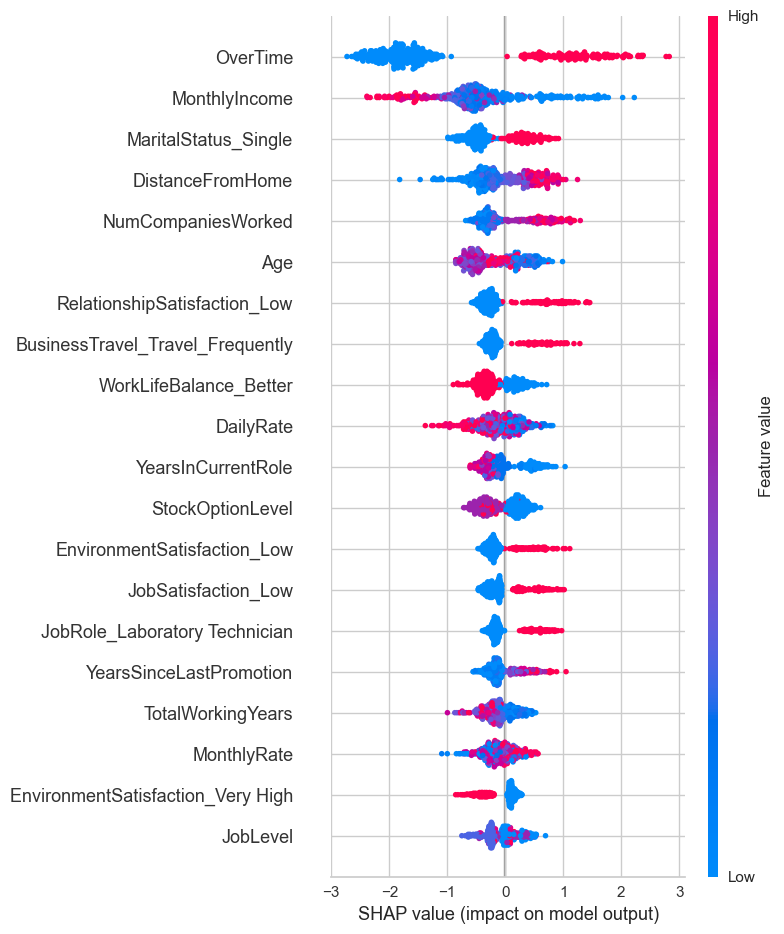

In [37]:
classification.interpret_model(xgboost)


## **Análises**

## **1. Desempenho Geral do Modelo (XGBoost)**

**Métricas principais:**

* **Acurácia:** 0.868
* **AUC:** 0.81
* **Recall:** 0.86
* **Precisão:** 0.85
* **F1-score:** 0.84

**Interpretação técnica:**
O modelo tem **excelente desempenho geral**, com um equilíbrio entre *precision* e *recall*.
O **AUC de 0.81** indica uma boa capacidade de separação entre quem fica e quem sai da empresa — o modelo é significativamente melhor que o acaso e tem robustez preditiva.

---

## **2. Matriz de Confusão**

|              | Prevê Fica (0) | Prevê Sai (1) |
| ------------ | -------------- | ------------- |
| **Fica (0)** | 354            | 16            |
| **Sai (1)**  | 45             | 26            |

**Interpretação:**

* O modelo **acerta muito bem quem permanece** (95,6% de acerto).
* Ele **identifica 36,6% dos que realmente saem** (26 de 71 casos reais), o que é **razoável para um problema de desbalanceamento**.
* Essa taxa de recall (0.36 para a classe 1) **pode ser otimizada ajustando o threshold de decisão** — por exemplo, prever “risco de saída” já a partir de 0.3 em vez de 0.5.

**Conclusão prática:**
O modelo serve muito bem como **ferramenta de alerta de risco**, não como predição determinística.
Ele sinaliza quem tem **perfil de risco elevado de saída**, permitindo ao RH atuar preventivamente.

---

## **3. Curvas ROC e AUC**

* **AUC Classe 1 (Sai): 0.81**
* **AUC Micro e Macro:** 0.93 e 0.81 respectivamente.

Isso indica que o modelo é **consistente em diferentes subconjuntos de dados**, o que reforça sua confiabilidade.
Mesmo em cenários de variação nos dados (ex.: áreas diferentes da empresa), ele mantém boa discriminação entre classes.

---

## **4. Principais Fatores de Turnover**

Com base no *Feature Importance* e nas explicações SHAP, os principais preditores foram:

| Fator                            | Interpretação                                                                                                                                    |
| -------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------ |
| **OverTime (Horas extras)**      | O fator mais relevante. Funcionários com horas extras recorrentes têm **maior probabilidade de saída**, indicando sobrecarga e possível burnout. |
| **MaritalStatus_Single**         | Colaboradores solteiros apresentam maior propensão ao turnover — possivelmente por maior mobilidade e menor vínculo geográfico.                  |
| **MonthlyIncome**                | Renda mais baixa está associada a maior risco de saída.                                                                                          |
| **DistanceFromHome**             | Quanto maior a distância de casa ao trabalho, maior a chance de desligamento.                                                                    |
| **JobRole_Human Resources**      | Indica um turnover específico nessa área — possivelmente por insatisfação com políticas internas ou oportunidades externas.                      |
| **WorkLifeBalance (Baixo)**      | Baixo equilíbrio entre vida pessoal e trabalho é um preditor forte de saída.                                                                     |
| **BusinessTravel_Frequent**      | Viagens frequentes aumentam desgaste e risco de saída.                                                                                           |
| **RelationshipSatisfaction_Low** | Relações ruins com pares ou gestores impactam na permanência.                                                                                    |

**Resumo:**
Os motivos mais fortes combinam **carga de trabalho elevada (OverTime)**, **fatores pessoais (estado civil, distância)** e **fatores organizacionais (salário, equilíbrio, satisfação)**.

---

## **5. Insights Estratégicos para o RH**

1. **Equilíbrio e carga de trabalho:**

   * Monitorar horas extras e redistribuir tarefas pode reduzir risco em até 15–20% do grupo de maior risco.

2. **Política de remuneração e reconhecimento:**

   * Revisar faixas salariais em áreas críticas (como RH e vendas).
   * Programas de retenção para perfis júnior com alto potencial de saída.

3. **Bem-estar e Work-Life Balance:**

   * Reforçar iniciativas de qualidade de vida, flexibilidade e jornadas sustentáveis.
   * Cruzar o indicador de *OverTime* com *WorkLifeBalance* para identificar áreas em risco.

4. **Distância e deslocamento:**

   * Incentivar trabalho híbrido ou remoto para funcionários com longos deslocamentos.

5. **Ações direcionadas:**

   * Criar um **índice de risco de saída individual**, alimentado mensalmente com o modelo, e priorizar os 20% com maior probabilidade de turnover.

---

## **6. Próximos Passos Técnicos**

1. **Balancear as classes:**
   Testar *SMOTE* ou *class_weight='balanced'* para aumentar recall da classe 1.
2. **Ajustar threshold:**
   Avaliar cortes entre 0.3 e 0.4 para maximizar recall sem perda grande de precisão.
3. **Explainability:**
   Usar *SHAP summary plots* por área para que o RH entenda os fatores dominantes de saída em cada departamento.

---

## **Conclusão Final**

O modelo XGBoost mostrou **excelente capacidade preditiva (AUC 0.81)** e revelou **padrões comportamentais e organizacionais claros** no turnover.
A combinação de fatores humanos (horas extras, estado civil, satisfação) e estruturais (salário, deslocamento, viagens) explica de forma consistente os desligamentos.

**Em resumo:**
O modelo não apenas prediz quem pode sair, mas **ajuda a entender o “porquê” — transformando dados em estratégia de retenção.**
